# assignment number 
## name, group etc


## Abstract:

In this project, we delve into the real world of epidemiological modeling by simulating a fictionalized zombie outbreak. 

Our main goal is to explore the dynamics of infection spread explicitly within a certain number of the population by running a Random Walk (RW) algorithm. This work will provide insights into the impact of various parameters on the survival of humans in the face of a relentless zombie apocalypse. The simulations are tested under different scenarios and assumptions, such as the custom scenario, Sokndal vs Dirdal, with different death rate of zombie to evaluate their effects on the population survival.

At the outset, a basic "Susceptible" or "Zombies (SZ) model is implemented in a two-dimensional space using Monte Carlo Random Walk algorithms, with varying the numbers of zombies spreading virus as initial setups. This model will later be updated as SZR with included Removed (R) individuals. The deterministic SZ model based on the ordinary differential equations (ODEs) is also implemented and compared with the RW model. We can notice that the result from both RW model and compartment ODEs model display similar overall trend where the human population diminishes as the zombie population grows, yet they diverge on the infection's velocity and stabilization timeline. This can be explained by the RW model captures the variability and unpredictability of real-world scenarios, while the ODEs model assumes a uniform rate of infection spread.

Our random walk montecarlo  model is further extended to include the scenario to check the conditional survival rate of unvaccinated population, conditioned on a certain population being vaccinated. Our model is set up in a way to make extending the model easy(using \*\*kwargs). 

## Introduction:

In the field of infectious diseases, understanding the mechanisms of disease transmission is crucial for guidance in defining effective control strategies. The infections often spread through contacts, a process intricately tied to the dynamics of the population movement. The mathematical modeling of infectious diseases has been a well-known challenge due to the unpredictability of human behavior. Therefore, it is meaningful that we explore and gain insights into the spread of infectious diseases, the importance of individual behaviors on population-level outcomes, and the utility of modeling tools in theoretical and applied epidemiology.

The virus transmission process can be modeled by Monte Carlo Random walk approach [4,5,6,7], as well as modeled using traditional compartmental models, which classify individuals into different compartments based on their infection status [1,3]. In this project of zombie virus outbreak, the infection status are included as "Susceptible", "Infected (Zombie)", "Recovered", and "Dead". 

Within this project, both stochastic RW and deterministic ODEs models are implemented and subjected to a comparative analysis. Various scenarios have been examined, with a focus on testing the impact of different parameters to assess the performance of each model.

---------------

In [1]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from time import sleep
pick_from = np.random.choice
from os import mkdir 
import pandas as pd
from scipy import integrate
import time
import matplotlib.animation as animation 
from IPython import display

In [5]:
np.random.seed(42) # to get reprodible results

## Exercise 1: Random walk SZ-model

SZ- model simulation include: 

- *The initial preparation:*
    - Create a $n_x \times n_y$ $ (50 \times 50)$ rectangular grid lattice.
    - Place $N$ (683) numbered human randomly at nodes within the rectangular grid at $t=0$ .
    - $Z$ numbered zombies out of the total number $N$, are considered to be placed randomly within the rectangular grid lattice.
    - $S = (N - Z)$, are considered to be susceptible to the zombies infection.  

**Execute a scenario:** the model can take an arbitrary set of events that occur in each time step and execute them in sequence. Some of the  events modeled are (called activites in the documentation)
- *Update walker position:*
    - All walkers can move randomly, either North, West, South, or East.
    - If a walker moves illegally outside of the rectangular grid, it will revert to the previous position.

- *Check the state:*
    - Check if the human walker is standing in the same position as the zombie, If yes, the human waker will be infected by the zombie and this human walker is going to be converted to the status of zombie. If not, the random walking process continues. 

**House keeping:** it is difficult to keep track of whats happening in the model unless we keep track of the state of the model. We have thus chosen to save any piece of data being generated and manipulated in the model. This of course leads to heavy memory use. This has the advantage of making the code run faster in case we need access to state of the model in previous steps. Our model being essentially a Markov chain (that is to say the state of our model at the next time step is dependent only on the current state of the model), it might not be necessary to save all the states, but we can now extend the model to have properties (such as vaccination state and infection rates) that are time dependent.  
- *Status history tracking:*
    - mark the number of human and zombies and store these numbers in a set of arrays. 
    - postion at each agent


**Visualizations:** the class provides methods basic visualizations. These are not used in our assignment. 
- *The simulation visualization:*
    - Plot and visualize the status of humans and zombies accordingly and the total number of humans and zombies. 

In [6]:
class DiseaseState(Enum):
    '''enumerates disease state of agents'''
    HUMAN = 2 # susspetible agents
    ZOMBIE = 1 # infected agents
    CURED = 0 # vaccinated/cured/recovered agents
    DEAD = 3  # dead
    
# extracting name and values of DiseaseState vectors (faster than loops)
def get_name(a):
    return(a.name)
def get_value(a):
    return(a.value)
v_get_name = np.vectorize(get_name)
v_get_value = np.vectorize(get_value)

In [7]:
class SZR():
    '''
    A Suseptible-Zombie-Recovered Random walk model
    '''
    
    #################################################################################################
    ### model setup
    #################################################################################################
    def __init__(self, population=683, infected=1, q=0.9, dp=0 , p_vax=0, nx=50, ny=50,**kwarg):
        '''
        Attribute:
            population : population of the a 'isolated' town. 
                         it is assumed no one gets in or out.
            infected   : how many agents are infected at the start of the simulation
            q          : conditional probablility of given contact the porbability of infection spread
            dp         : conditional probablility of given contact the porbability of zombie dies
            p_vax      : percentage of the population vaccinated
            nx         : number of spatial grids along x-axis
            ny         : number of spatial grids along y-axis
            
        '''

        self.q = q 
        self.dp = dp
        self.p_vax = p_vax 
        self.infected = infected
        self.make_walls(nx, ny) 
        self.make_agents(population)
        self.put_in_seed_zombie(infected)
        self.vaccinate(p_vax)
        # self.kill_immunize(1)
        self.make_legal_moves()

        
    def make_walls(self, nx, ny):
        '''
        stores the number of grid points (nx, ny)
        and top(ny-1), bottom(0), left(0), and right(nx-1) wall positions.
        all the 'agents' spawn and move single step up, down, right or left
        '''
        self.nx = nx  # number of x grid points
        self.ny = ny  # number of y grid points
        self.topwall = ny-1
        self.bottomwall = 0
        self.leftwall = 0
        self.rightwall = nx-1
        
    def make_agents(self, population):
        '''
        makes arrays representing a population of size N the 
            id: identifier of the agent, array len=N
            loc : location of the agent on the map  array[N,2]
            infection_status : is the agent infected, len=N 
                               we initiate the whole population as healthy 
                               0 : zombie scum
                               1 : healthy/suspetible
                               2 : cured (she turned me into a newt, 
                                          but i got better)
                               3 : the grateful dead
         '''
        self.population = population
        self.id = np.arange(self.population)

        possible_x_locs = np.arange(self.nx)
        possible_y_locs = np.arange(self.ny)
        self.xlocs = pick_from(possible_x_locs, self.population)
        self.ylocs = pick_from(possible_x_locs, self.population)
        # above we could simply have written
        # xlocs = np.random.choice(self.nx, self.population)
        # but it might be complex to read

        #self.location = np.array([xlocs, ylocs])

        self.infection_status = np.full(self.population, DiseaseState.HUMAN)
        
        
    def put_in_seed_zombie(self, infected):
        '''
        converts infected number of agents to zombies who can now infect healthy agents
        '''
        # use 'replace = False ' to pick unique agents to infect
        who_is_zombified = pick_from(self.id, infected, replace=False)
        self.infection_status[who_is_zombified] = DiseaseState.ZOMBIE
        # print(self.infection_status)
        
    def vaccinate(self, p_vax):
        '''
        vaccinate a percentage of the population
        '''
        number_vaccinated = np.round((self.population-self.infected)*p_vax)
        number_vaccinated = int(number_vaccinated)
        human_ids = self.id[self.infection_status == DiseaseState.HUMAN]
        who_is_vaccinated = pick_from(human_ids, number_vaccinated,replace=False)
        self.infection_status[who_is_vaccinated] = DiseaseState.CURED
        #print('vaccinate', number_vaccinated, 'humans')
        
        
        
    def make_legal_moves(self):
        '''
        initiates helper attributes to move the agents
        creates:
            moves : human readable move keywords
            move_increments : move values in numbers; up =[0,1] etc.
            move_dict ={moves:move_increment}
            we also add an option 'no_move'= [0,0] where agent doesnt move 
        '''
        self.moves = ['up', 'down', 'left', 'right']
        self.moves_increments = [[0, 1], [0, -1], [-1, 0], [1, 0]]
        self.move_dict = {a: b for a, b in zip(
            self.moves, self.moves_increments)}
        self.move_dict['no_move'] = [0, 0]

    
    def kill_immunize(self, k):
        '''
        for testing: kills one  random agent          
        '''
        who_is_killed = pick_from(self.id, k)
        self.infection_status[who_is_killed] = DiseaseState.DEAD
        who_is_immunized = pick_from(self.id, k)
        self.infection_status[who_is_immunized] = DiseaseState.CURED
    
    ##################################################################################

    #################################################################################################
    ### basic plotting 
    #################################################################################################

    def beautify_grid(self, ax):
        ax.set_xlim([-1, self.nx])
        ax.set_ylim([-1, self.ny])
        ax.grid(linestyle='--', alpha=0.3)
        ax.set_aspect('equal')

    def get_x_y(self, inf_status):
        selected = np.where(self.infection_status == inf_status)
        x = self.xlocs[selected]
        y = self.ylocs[selected]
        return(x, y)

    def plot_locs(self, ax, **kwargs):
        colors = {'HUMAN': 'green', 'ZOMBIE': 'red',
                  'CURED': 'cyan', 'DEAD': 'black'}
        s = {'HUMAN': 5, 'ZOMBIE': 3, 'CURED': 7, 'DEAD': 10}

        color = [colors[i.name] for i in self.infection_status]
        s = [i.value*20+3 for i in self.infection_status]

        # s=
        '''
        for inf_status in [0,1,2]:
            x,y=self.get_x_y(inf_status)
            ax.scatter(x,y,color=c[inf_status],**kwargs)
        '''
        ax.scatter(self.xlocs, self.ylocs, color=color,
                   s=s, alpha=0.5)
        self.beautify_grid(ax)
        
    #################################################################################################
    
    
    #################################################################################################
    ### Class methods to ease calculations 
    #################################################################################################
    
    @classmethod
    def to_tuple(cls, a):
        return ([tuple(i) for i in a])

    @classmethod
    def common_coordinates(cls, a, b):
        '''
        takes two lists of coordinates and returns the coordates that are in common
        as we use set operations each element of the list is converted to a tuple 
        '''
        #nptuple = np.vectorize(tuple)
        a = set(cls.to_tuple(a))
        b = set(cls.to_tuple(b))
        common = a.intersection(b)
        common = [i for i in common]
        return(common)
    
    #################################################################################################
    

    #################################################################################################
    ### Housekeepers: methods to save sim data, turn them into dataframe, get stats from the sim etc
    #################################################################################################

    def save_sim_dat(self):
        folder_name = f'pop{self.population}_infected{self.infected}{np.random.get_state()[1][0]}'
        mkdir(folder_name)
        with open(f'{folder_name}/output.txt', 'w') as f:
            f.write('x locations:\n')
            f.write(repr(pop.sim_xlocs))
            f.write('\ny locations:\n')
            f.write(repr(pop.sim_ylocs))
            f.write('\nmoves:\n')
            f.write(repr(pop.sim_moves))
            f.write('\ninfection status:\n')
            f.write(repr(pop.sim_infection_status))
        print('wrote sim data')

    def show_disease_count(self, t, every=10):
        # prints status every 10th time step
        if every == 0:
            return()

        if t % every == 0:
            s = f'Population count at time step {t:>3}:    '
            for i in DiseaseState:
                s = s+f'{i.name}: {np.sum(self.infection_status==i):>3},   '
            s = s.strip()[:-1]+'.'
            print(s)
        else:
            pass

    def to_DataFrame(self):
        '''Returns a Pandas dataframe of the simulated data'''
        data = {'time': range(self.sim_T+1),
                'xlocs': self.sim_xlocs, 'ylocs': self.sim_ylocs,
                'infection_status': self.sim_infection_status}
        df = pd.DataFrame(data)
        self.sim_df = df
        return(df)

    def get_stats(self, a):
        ds = v_get_name(a)
        counts = []
        for state in self.states:
            counts.append(len(ds[ds == state]))
        return counts

    def get_sim_stats(self):
        '''
        returns a Dataframe containing the number of agents 
        in each disease
        '''
        self.sim_data_df = self.to_DataFrame()
        self.states = [i.name for i in DiseaseState]
        data = self.sim_data_df.infection_status.apply(self.get_stats).tolist()
        self.sim_stats_df = pd.DataFrame(data=data, columns=self.states)
        return self.sim_stats_df
    
    #################################################################################################
    
    
    #################################################################################################
    ### Activities: methods that move the agents, infect them, kill them etc
    ### we can combine them in any order or combination to execute a scenario
    #################################################################################################
    
    def revert_illegal_moves(self, new_xlocs, new_ylocs):
        
        # check for illegal moves
        illegalx = np.where(new_xlocs < self.leftwall)
        new_xlocs[illegalx] = self.leftwall
        illegalx = np.where(new_xlocs > self.rightwall)
        new_xlocs[illegalx] = self.rightwall
        illegaly = np.where(new_ylocs < self.bottomwall)
        new_ylocs[illegaly] = self.bottomwall
        illegaly = np.where(new_ylocs > self.topwall)
        new_ylocs[illegaly] = self.topwall
        
        return(new_xlocs, new_ylocs)
    
    def move_agents(self):
        '''
        moves each agent, alive and zombified one step, up , down, left or right
        the dead agents dont move
        if any of them move outside town they are brought back in 
        '''
        # select random walk for all agents
        steps_ = pick_from(self.moves, self.population)
        # print(self.infection_status,'\n',steps)

        # finds where which agents are dead , set them to no move and keep the other moves
        steps_ = np.where(self.infection_status ==
                          DiseaseState.DEAD, 'no_move', steps_)
        # print(steps)
        # convert steps from strings to move steps
        # and transpose so it can be easily added to xlocs and ylocs
        steps = np.array([self.move_dict[i] for i in steps_]).T
        new_xlocs = steps[0]+self.xlocs
        new_ylocs = steps[1]+self.ylocs
        # print(new_xlocs,self.xlocs)
        # print(new_ylocs,self.ylocs)

        new_xlocs, new_ylocs = self.revert_illegal_moves(new_xlocs, new_ylocs)

        return(new_xlocs, new_ylocs, steps_)
    

    def check_infected_contact(self):
        '''
        checks if zombies comes in contact with a healthy agent
        '''

        #multiple_agent_locs = self.check_where_agents_meets()

        infected_id = np.where(self.infection_status == DiseaseState.ZOMBIE)
        #  infected_locs are where zombies are present
        infected_locs = np.array(
            [self.xlocs[infected_id], self.ylocs[infected_id]]).T
        #print('locations where zombies are present:', infected_locs)

        human_id = np.where(self.infection_status == DiseaseState.HUMAN)
        #  human_locs are where zombies are present
        human_locs = np.array(
            [self.xlocs[human_id], self.ylocs[human_id]]).T
        #print('locations where humans are present:', human_locs)

        # find where both humans and zombies are present
        infection_contact_locs = self.common_coordinates(
            human_locs, infected_locs)
        print('locations where both humans and zombies are present:',
              infection_contact_locs)

        return(infection_contact_locs)
    
    def zombie_death(self):
        '''
        kill zombies randomly at a probability of dp
        '''
        
        zombie_id = np.where(self.infection_status == DiseaseState.ZOMBIE)[0]
        number_of_zombies = len(zombie_id)
        #print('number of zombies', number_of_zombies)
        
        death_happens = np.random.uniform(0,1,number_of_zombies) < self.dp
        #print(death_happens)
        zombies_dead = zombie_id[death_happens]
        self.infection_status[zombies_dead] = DiseaseState.DEAD
        return(self.infection_status)
        

    def spread_infection(self, kill_inplace_zombies=False):
        '''
        this is how we spread the disease. 
         1. find where zombies are. [infected locs]
         2. find if there are humans at these locations.
         3. if a location is infected and there are 
            humans (suspetible) present, then try to infected the human
         return 
        at each infection location check if the Human gets infected 
        by the zombies present at the location

        The probability of a healthy human being infected by a zombie, 
        base probablity = q 

        In a compounded scenario, we have assumed that the higher the number of 
        zombies present at a location the higher is the probability of infection.
        So at a location with N zombies present the probability of infecting each
        heathy human is 
        (1 - (1-q)^N)
        '''

        infection_status = self.infection_status.copy()

        # infected_id = bool list, maps to true if Zombie false otherwise.
        infected_id = np.where(infection_status == DiseaseState.ZOMBIE)[0]
        #  infected_locs = location where zombies are present
        infected_locs = np.array(
            [self.xlocs[infected_id], self.ylocs[infected_id]]).T
        #print('locations where zombies are present:', infected_locs)

        human_id = np.where(infection_status == DiseaseState.HUMAN)[0]
        #  human_locs are locations where humans are present
        human_locs = np.array(
            [self.xlocs[human_id], self.ylocs[human_id]]).T
        #print('locations where humans are present:', human_locs)

        # find where both humans and zombies are present
        infection_contact_locs = self.common_coordinates(
            human_locs, infected_locs)
        # print('locations where both humans and zombies are present:',
        #      infection_contact_locs)

        # print(infection_contact_locs)
        #infected_id = infected_id[0]

        for loc in infection_contact_locs:
            # print('-'*80)

            #zombies_here = boolian
            zombies_here = np.where((infected_locs == loc).all(axis=1))[0]
            zombies = infected_id[zombies_here]
            number_of_zombies = len(zombies_here)

            humans_here = np.where((human_locs == loc).all(axis=1))[0]
            humans = human_id[humans_here]
            number_of_humans = len(humans_here)
            #print('old infection status',self.infection_status[humans])
            
            # the more zombies present at a location the higher the probability
            # probability of infection = 1- probability of survival
            # probability of survival = (1-q)**(number of zombies)
            infection_probability = 1-(1-self.q)**number_of_zombies

            #spread infection to the humans present at this location
            infection_happens = np.random.rand(number_of_humans) < infection_probability
            humans_infected = human_id[humans_here[infection_happens]]
            infection_status[humans_infected] = DiseaseState.ZOMBIE
            
            if kill_inplace_zombies:
                
                #kill zombies that are present at this location
                death_happens = np.random.rand(number_of_zombies) < self.dp
                zombies_dead = infected_id[zombies_here[death_happens]]
                infection_status[zombies_dead] = DiseaseState.DEAD
        
            
        return(infection_status)
    
    
    
    #############################################################################
    
    
    #############################################################################
    ### Scenarios 
    ### the model can be extended by defining different 'activity' methods in the 
    ### section above and 
    #############################################################################

    def move_infect_die(self):
        '''
        In this event sequncy the agents move, then zombies infect suseptible individuals and 
        finally zombies die randomly
        '''
        # move agents
        self.xlocs, self.ylocs, steps = self.move_agents()
        # spread infection
        self.infection_status = self.spread_infection()
        #kill zombies
        self.zombie_death()
        
    def move_infect_die_inplace(self):
        '''
        not used  
        '''
        # move agents
        self.xlocs, self.ylocs, steps = self.move_agents()
        # spread infection: if humans and zombies coexist
        self.infection_status = self.spread_infection()
        
        
    #############################################################################
    

    
    #############################################################################
    ### simulation in time domain 
    #############################################################################
    
    def zombie_apocalyps_sim(self, T, every=0, ax=None, scenario = 'default', write_data=False,**kwarg):
        '''
        Simulates infection spread in T time steps
        every : show number of human and zombies as every number of time step
        write_data: bool, will write file to folder or not
        '''
        # set scenenario:
        match scenario:
            case 'default':
                self.event_cycle=self.move_infect_die
            case 'move_infect_die_inplace':
                self.event_cycle = self.move_infect_die_inplace
                
        
        #store initial condition of the population
        self.sim_T = T
        self.sim_xlocs = [self.xlocs]
        self.sim_ylocs = [self.ylocs]
        self.sim_infection_status = [self.infection_status]
        # print(v_get_value(self.infection_status))
        #self.sim_moves = []

        # print('='*80)
        self.show_disease_count(0, every=every)
        # print('='*80)

        for t in range(T):
            #print('time:', t)
            # self.plot_locs(ax)

            # check which locations can cause the infection to spread
            # for this a healthy agent and an infected agent need to be at
            # the same node
            #infection_locs = self.check_infected_contact()

            #
            self.event_cycle()
            
            # for debugging: shows number of humans, zombies etc 
            self.show_disease_count(t+1, every=every)

            # save simulation state
            self.sim_xlocs.append(self.xlocs)
            self.sim_ylocs.append(self.ylocs)
            #self.sim_moves.append(steps)
            self.sim_infection_status.append(self.infection_status)
            # print(v_get_value(self.infection_status))
            # sleep(1)
        # create dataframe with time wise location and infection status
        self.to_DataFrame()
        # write data to a location if requested
        if write_data:
            self.sim_df.to_csv('sim_data.csv')
        self.get_sim_stats()

**Animation**
The following function `show_Zombieland` produces animations from simulation data. Each 'kind' of agent is colored differently. We provide a variable to control the time between each frame of the animation and a skip parameter that lets us skip frames to display. 

We also show events were infection happens and where a zombie dies. Dead zombies don't move.

Please note 'ffmpeg' NEEDS to be installed on the machine to make this function work

In [8]:
def show_Zombieland(sim_data_df, T = None, slowness = 100, skip=1):
    '''
    This function shows  how the apocalpse unfolds in our fictional town.
    
    parameters:
        T = how many hours of the simulation to show 
            if set to None, all the whole simulation  will be shown.
        skip = how many days to skip between each frame of the animation
               default is 1, that is every single day of the simulation isn shown 
               to show every other day set skip to 2 and so on 
        slowness = pause between each frame in ms
        
    '''
    # fix time
    if T is None:
        T = len(sim_data_df)-1
    interval = slowness
    
    #color things to make them pretty
    color_dict = {'HUMAN':'g', 'ZOMBIE':'r', 'DEAD':'k', 'CURED':'cyan' }
    change_color_dict = {'ZOMBIE':'b', 'DEAD': 'k'}
    
    def color_by_status(a):
        #color codes by infection status
        c = np.ones_like(a)
        names = v_get_name(a)
        #print(v_get_name(a))
        for i, col in color_dict.items():
            cat = np.where(names==i)[0]
            c[cat] = col
        return c
    
    def color_change(inf):
        #print(inf)
        ec = np.ones_like(inf)
        names  = v_get_name(inf)
        #print(v_get_name(a))
        for i, col in change_color_dict.items():
            cat = np.where(names==i)[0]
            ec[cat] = col
        return ec

    def get_sim_data(df,t):
        df = df[df.time==t]
        x = df.xlocs.to_numpy()[0]
        y = df.ylocs.to_numpy()[0]
        inf_status = df.infection_status.to_numpy()[0]
        #print(inf_status)
        c = color_by_status(inf_status)
        return(x,y,c)
    
    def get_changes(df,t):
        inf0 = df[df.time==t-1].infection_status.to_numpy()[0]
        inf1 = df[df.time==t].infection_status.to_numpy()[0]
        
        idx = np.where(inf1!=inf0)[0]
        if len(idx)==0:
            return([],[],[])
        ex = df[df.time==t].xlocs.to_numpy()[0][idx]
        ey = df[df.time==t].ylocs.to_numpy()[0][idx]
        ec = color_change(inf1[idx])
        return(ex,ey,ec)
        
    # initiate plot. 

    # creating a blank window 
    # for the animation 
    fig = plt.figure() 
    axis = plt.axes(xlim =(-1, 50), 
                    ylim =(-1, 50)) 
    
    t = 0
    axis.set(aspect='equal')
    #tit = axis.set(title=f'Zombie Apocalyps!')

    x,y,c = get_sim_data(sim_data_df, t) 
    #print(len(x), len(y), len(c))
    #print(np.unique(c, return_counts=True))
    dots = axis.scatter(x,y, c=c, s = 10) 
    ttl = axis.text(.45, 1.005, f'Hours since infection start: {0:>3}', transform = axis.transAxes)
    changes = axis.scatter([],[],s = 75, facecolor='none', marker = '*')

    def animate(i): 
        #print(i)
        t = i+1
        x,y,c = get_sim_data(sim_data_df, t) 
        xy = np.array([x,y]).T
        c = c.T
        
        ex,ey,ec = get_changes(sim_data_df, t) 
        exy = np.array([ex,ey]).T
        ec = np.array(ec).T
        
        #print(xy.shape)
        dots.set_offsets(xy)
        dots.set_facecolor(c) 
        changes.set_offsets(exy)
        changes.set_edgecolor(ec)
        ttl.set_text(f'Hours since infection start: {i:>3}')
        return dots,ttl,changes,

    # calling the animation function     
    frames = range(0,T,skip)
    anim = animation.FuncAnimation(fig, animate, 
                                frames = frames,
                                interval = slowness, 
                                blit = True) 

    # if animation doesnt work check  if you have installed ffmpeg
    axis.scatter([],[], s=10, c='red', label = 'ZOMBIES')
    axis.scatter([],[], s=10, c='green', label = 'HUMANS(S)')
    axis.scatter([],[], s=10, c='black', label = 'DEAD')
    axis.scatter([],[], s=75, marker='*' ,facecolor='none', edgecolor='b', label = 'infection event')
    axis.scatter([],[], s=75, marker='*' ,facecolor='none', edgecolor='k', label = 'death event')
    
    #axis.legend(bbox_to_anchor=(1.1, 1.05))
    axis.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
    plt.tight_layout()
    
    video = anim.to_html5_video()
    #anim.to_jshtml()
    html = display.HTML(video)
    display.display(html)
    plt.close()

**Question 1:** Assume that there is a single zombie initially, $Z(0) = 1$, what is the fate of the zombie and human population?

In this stage, the given condition is:

- $N = 683$, the total human population is 683.
- $Z(0) = 1$,  only one zombie initially.
- The grid $n_x \times n_y  = 50 \times 50$.
- $q = 0.9$,  the probability of getting infected is 90%.
- $t = 300$. each run is 300 time steps long.
- The simulation runs visualization: 5 times, 10 times, 50 times, 100 times.

In [9]:
#%%capture cap --no-stderr # for debuggin, captures console output and can weite it into a log file 
population = 683
infected = 1
nx = 50
ny = 50
T = 300
pop = SZR(population=population, infected=infected, nx=nx, ny=ny)
pop.zombie_apocalyps_sim(T=T)
sim_data_df = pop.to_DataFrame()


The animation below shows the fate of the town for a single run of the model.

In [11]:
show_Zombieland(sim_data_df,skip=2, slowness=100)

In [12]:
def randomwalk_mc(samples=100, population=683, infected=1, nx=50, ny=50, T=400):
    '''
    Performs monte carlo simulation for the random walk model
    parameters:
    samples: number of simulations to perform
    '''
    mcresults =[]
    for i in range(samples):
        pop = SZR(population=population, infected=infected, nx=nx, ny=ny)
        pop.zombie_apocalyps_sim(T=T)
        sim_stats_df = pop.get_sim_stats()
        sim_stats_df['sim_no']=i
        sim_stats_df['sim_time'] = sim_stats_df.index
        mcresults.append(sim_stats_df)
    return(pd.concat(mcresults))
    

In [13]:
def run_mc(samples = 100,**kwargs):
    mc_results = randomwalk_mc(samples=samples,**kwargs)
    mc_averaged_data = mc_results.groupby('sim_time')[mc_results.columns[:-2]].agg(['mean','std'])
    return mc_averaged_data

In [14]:
def plot_mc_results(ax, mc_averaged_data , cats = ['HUMAN', 'ZOMBIE'],show_band=True):
    '''
    Takes the dataframe of averaged counts of categorical data and lots them
    '''
        
    data = mc_averaged_data[cats]
    t = data.index
    for cat in cats:
        mean = data[cat,'mean']
        std = data[cat,'std']
        ax.plot(t, mean,'--', label = cat+'-RW')
        if show_band:
            ax.fill_between(t,mean+std, mean-std, color = 'grey', alpha = 0.3)
    ax.grid()
    ax.legend()
    return(ax)

## Question 1: 
Assume that there is a single zombie initially, Z(0) = 1, what is
the fate of the zombie and human population? 

time taken to run 5 simulations = 1.29s
time taken to run 10 simulations = 2.50s
time taken to run 50 simulations = 12.62s
time taken to run 100 simulations = 25.30s
time taken to run 200 simulations = 50.19s
time taken to run 300 simulations = 75.37s


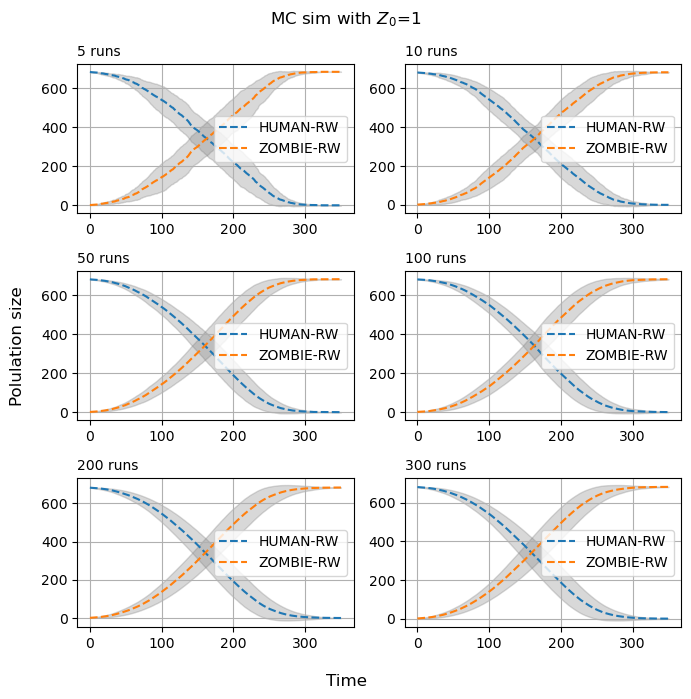

In [15]:
sizes = [5,10,50,100,200,300]
z0,T =1,350
fig, axs = plt.subplots(nrows = 3, ncols=2, figsize = (7,7))
axs = np.ndarray.flatten(axs)
for size,ax in zip(sizes,axs): 
    a = time.time()
    mc_averaged_data = run_mc(samples=size, infected=z0,T=T)
    plot_mc_results(ax, mc_averaged_data)
    ax.set_title(f'{size} runs', loc ='left', fontsize = 10)
    b = time.time()
    print(f'time taken to run {size} simulations = {b-a:.2f}s')
fig.suptitle(f'MC sim with $Z_0$={z0}')
fig.supxlabel('Time')
fig.supylabel('Polulation size')
plt.tight_layout()

**Discussion:**
A random walk model, as the name suggests, simulates the 'state evolution' of a model using random perturbances. To increase confidence in our model and for the results to be statistically significant we need to run the model a number of times (Monte Carlo sims) and thus compute the 'most likely' outcome of the simulation. In the above figure we show how the number of simulation changes the confidence we can have on the stability of the model. As can be observed from the figure above, running the model 50-100 times and averaging the results produces a stable model. 

At t = 150, it is evident that a substantial portion of the population, nearly 380 individuals, have been exposed to the zombie virus infection. By t = 300, the entire population undergoes infection, transforming all people into zombies. This progression is explicitly shown in the animation above. We also observe that the human population decreases sharply initially, which suggests that a single zombie can have a significant impact on an uninfected population, leading to a rapid spread of the infection. The confidence interval is shown in the gray shaded zone that is subjected to be wider when the simulation run from 5 to 100 times, which suggests a greater degree of stability.

## Question 2: 
If we instead started with Z(0) = 10, how does the time evolution
change?

time taken to run 5 simulations = 0.73s
time taken to run 10 simulations = 1.46s
time taken to run 50 simulations = 7.32s
time taken to run 100 simulations = 14.50s
time taken to run 200 simulations = 29.01s
time taken to run 300 simulations = 43.99s


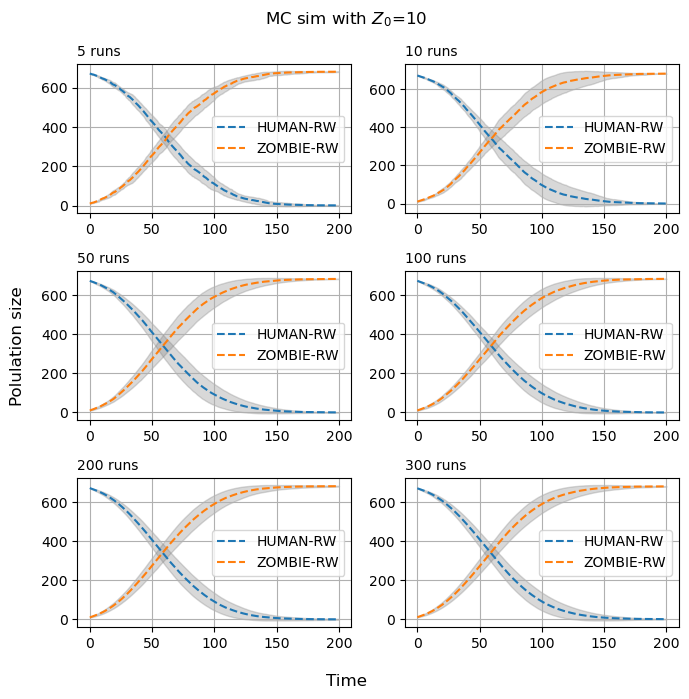

In [16]:
sizes = [5,10,50,100,200,300]
z0,T =10,200
fig, axs = plt.subplots(nrows = 3, ncols=2, figsize = (7,7))
axs = np.ndarray.flatten(axs)
for size,ax in zip(sizes,axs): 
    a = time.time()
    mc_averaged_data = run_mc(samples=size, infected=z0,T=T)
    plot_mc_results(ax, mc_averaged_data)
    ax.set_title(f'{size} runs', loc ='left', fontsize = 10)
    b = time.time()
    print(f'time taken to run {size} simulations = {b-a:.2f}s')
fig.suptitle(f'MC sim with $Z_0$={z0}')
fig.supxlabel('Time')
fig.supylabel('Polulation size')
plt.tight_layout()

**Discussion:**

By starting with ten zombies instead of one, it leads to a similar outcome but at a faster rate. The same substantial portion of the population, nearly 380 individuals, have been infected by zombie virus roughly at t = 60, instead of t = 150 with one zombie scenario. At t = 150, nearly the entire population transformed into zombies. The rate of virus spreading is approximately twice as fast as the previous initial setting. It is also noticeable that the a steeper decline in the human population right from the beginning of the simulation. The confidence interval shown in the gray-shaded zone remains to be narrow compared to the previous setting, which suggests a higher degree of precision.

# Exercise 2: Compare random walk and ODEbased models

**Theory**: 

The ODE-based, deterministic SZ-model is:

\begin{align}
\frac{dS(t)}{dt} =-\beta(t)\cdot \frac{S(t)Z(t)}{N} \tag{1}\\
\frac{dZ(t)}{dt} =\beta(t)\cdot \frac{S(t)Z(t)}{N}  \tag{2}\\
\end{align}

SZR-model is
\begin{align}
\frac{dS(t)}{dt}&=-\beta(t)\cdot \frac{S(t)Z(t)}{N}  \tag{3}\\
\frac{dZ(t)}{dt}&=\beta(t)\cdot \frac{S(t)Z(t)}{N} - \frac{1}{\tau_{death}\cdot}Z(t)  \tag{4}\\
\frac{dR(t)}{dt}&=\frac{1}{\tau_{death}\cdot}Z(t)   \tag{5}\\
\end{align}


where $S(t)$ is the number of humans (susceptible) at time $t, Z(t)$ denotes the number of zombies and $N = S(t) + Z(t)$ is the total population size. $\beta$ can
be viewed an effective contact (disease transmission) rate; the total number of effective contacts made by any individual per unit time, multiplied with the
probability of infection. The actual rate at which susceptible individuals become infected are given by the product $\beta(t)Z(t)/N$, sometimes referred to as the
*force of infection*. $R(t)$ is the number of "Removed" individuals or dead zombies at time t and $\tau_{death}$ represents the mean life time of zombies. If $\tau_{death} \rightarrow \infty$, a zombie lives forever, and the equations above reduce to the SZ-model.

If we assume a constant $\beta$ , the analytical solution is

\begin{align}
Z(t) = \frac{N}{1 + \frac {S_0}{Z_0} exp (-\beta t)} \tag{6}\\
S(t) = N - Z(t) \tag{7}\\
\end{align}

In order to estimate the constant $\beta$, the following equation is used:

\begin{equation}
\beta_n \cdot \Delta t \approx - \frac{(S_n - S_{n-1})N}{S_n Z_n} \tag{8}
\end{equation}


To estimate $\tau_{death}$ from the simulations

\begin{equation}
\frac{\Delta t}{\tau_{death}} = \frac{R_n - R_{n-1}}{Z_n}  \tag{9}
\end{equation}

where $R_n$ is the number of dead zombies at time $t_n$


It should be noted that each random walk infection rate is different and is based where the agents were initially placed and how they randomly walk around. Since the time for which we run each RW simulation is same it can happen that $S(t)$ becomes 0, thus producing $\beta \Delta t = \infty$. It is thus important to ignore these values when computing mean values. In our functions we have `np.nanmean` to avoid this problem.

In [17]:
class MCRW():
    '''
    provides methods to perfoming monte carlo simulation of the random walk
    '''

    def __init__(self, samples=100, model=SZR):
        self.samples = samples
        self.model = model

    def randomwalk_mc(self, **kwargs):
        '''
        Performs monte carlo simulation for the random walk model
        parameters:
        samples: number of simulations to perform
        kwarg = population=683, infected=1, nx=50, ny=50, T=400
        '''
        mcresults = []
        modelresults = []
        for i in range(self.samples):
            pop = self.model(**kwargs)
            pop.zombie_apocalyps_sim(**kwargs)
            # print(pop.sim_T)

            sim_model_df = pop.to_DataFrame()
            sim_model_df['sim_no'] = i
            #sim_model_df['sim_time'] = sim_model_df.index
            modelresults.append(sim_model_df)

            sim_stats_df = pop.get_sim_stats()
            sim_stats_df['sim_no'] = i
            sim_stats_df['sim_time'] = sim_stats_df.index
            mcresults.append(sim_stats_df)

            # print(sim_data_df)
        self.modelresults_df = pd.concat(modelresults)
        self.mcresults_df = pd.concat(mcresults)
        return(self.mcresults_df)

    def run_mc(self, **kwargs):
        mc_results = self.randomwalk_mc(**kwargs)
        mc_averaged_data = mc_results.groupby(
            'sim_time')[mc_results.columns[:-2]].agg(['mean', 'std'])
        self.averaged_mc_df = mc_averaged_data
        self.modelresults_df = self.add_interactions_column()
        #self.find_beta_tau()
        return mc_averaged_data

    def add_interactions_column(self):
        df = self.modelresults_df
        xlocs, ylocs = df.xlocs.to_numpy(), df.ylocs.to_numpy()
        interactions = []
        for x, y in zip(xlocs, ylocs):
            interactions.append(self.calc_no_of_interactions(x, y))
        interactions = np.array(interactions)
        df['avg_interactions'] = interactions/params['population']
        return df

    def calc_no_of_interactions(self, x, y):
        a = np.array([x, y]).T
        uniques, counts = np.unique(a, return_counts=True, axis=0)
        # print(uniques,counts)

        more_than_one = counts > 1
        counts = counts[more_than_one]
        # if n agents are presnt at a location, number of interactions
        # nc2 =n*(n-1)
        interactions = np.sum(counts*(counts-1))
        return(interactions)

    def find_beta_tau(self):
        df = self.mcresults_df
        betas = []
        taus = []
        for i in range(self.samples):
            _df = df[df.sim_no == i]
            S = _df.HUMAN.to_numpy()
            Z = _df.ZOMBIE.to_numpy()
            D = _df.DEAD.to_numpy()
            N = params['population']
            
            beta = (S[1:]-S[:-1])*N/(S[1:]*Z[1:])
            idx = np.where(1/beta != 0)[0]
            beta = np.nanmean(beta[idx])

            tau = ((D[1:]-D[:-1])/Z[1:])
            idx = np.where(1/tau != 0)[0]
            tau = np.nanmean(tau[idx])

            betas.append(beta)
            taus.append(tau)
            # print(tau)
            # break
        self.avg_beta = -np.mean(betas)
        self.avg_tau = 1/np.mean(taus)

        #print('avg beta ', self.avg_beta)
        #print('avg tau ', self.avg_tau)
        return(self.avg_beta, self.avg_tau)

    def __call__(self, **kwargs):
        pass

\begin{align*}
\frac{dS(t)}{dt}&=-\beta(t)\cdot \frac{S(t)Z(t)}{N}\\
\frac{dZ(t)}{dt}&=\beta(t)\cdot \frac{S(t)Z(t)}{N} - \frac{1}{\tau_{death}\cdot}Z(t)\\
\frac{dR(t)}{dt}&=\frac{1}{\tau_{death}\cdot}Z(t)\\
\end{align*}

In [18]:
class BucketModel():
    '''
    provides solution to continum OED models
    
    \begin{align*}
    \frac{dS(t)}{dt}&=-\beta(t)\cdot \frac{S(t)Z(t)}{N}\\
    \frac{dZ(t)}{dt}&=\beta(t)\cdot \frac{S(t)Z(t)}{N} - \frac{1}{\tau_{death}\cdot}Z(t)\\
    \frac{dD(t)}{dt}&=\frac{1}{\tau_{death}\cdot}Z(t)\\
    \end{align*}
    
    population is split into Susseptible(S), Zombies(S), Dead or Debrained (D)
    infection rate is β(t). Death/Decaptation rate is τ_death
    '''
    def __init__(self,N=683, Z0=10,D0=0,T=200, beta=0.9, tau=np.inf, size = 100):
        '''
        params
        N: total population
        Z0: number of zombies at t=0
        T : time for which sim runs (unit agnostic, so keep units consistent)
        size : 1/dt 
        beta: infection rate, conditional probability that an encounter will result in a 
        pd: probability that a zombie human interaction ends in the death of a zombie
        '''
        self.N=N
        self.Z0=Z0
        self.D0=D0
        self.S0=self.N-self.Z0-self.D0
        self.beta=beta
        self.tau = tau
        self.t = np.linspace(0,T,size+1)
        
    #@classmethod
    def ODE_analytical(self):
        '''
        provides the analytical solution to the OED model.
        \tau and 
        '''
        #S0 = N-Z0
        Zt = self.N/(1+self.S0/self.Z0*np.exp(-self.beta*self.t))
        return(self.t,self.N-Zt,Zt)

    #@classmethod
    def ODE_SZ_model(self):
        '''
        Provides the solution from integration of equations
        '''
        
        def rhs(X, t):
            S, Z, R = X
            
            return [-beta*S*Z/N, +beta*S*Z/N - Z/tau, +Z/tau]

        #X0 = np.array([N-Z0-R0, Z0, R0])
        N=self.N
        beta=self.beta
        tau=self.tau
        X0 = [self.S0, self.Z0, self.D0]
        sol = integrate.odeint(rhs, X0, self.t)
        return self.t, sol


In [19]:
params = {'population':683, 'infected':10, 'q':0.9, 'nx':50, 'ny':50, 'T':180}
samples = 100
mcmodel=MCRW(samples=samples)
_ = mcmodel.run_mc(**params)
mcmodel
mcmodel.find_beta_tau()
beta = mcmodel.avg_beta
a = BucketModel(beta=beta, size = 200)
t_ana,S_ana,Z_ana = a.ODE_analytical()
t_ode,soln = a.ODE_SZ_model()
S_ode, Z_ode = soln[:,0],soln[:,1]

/tmp/ipykernel_659/4163414050.py:81: RuntimeWarning: divide by zero encountered in divide
  beta = (S[1:]-S[:-1])*N/(S[1:]*Z[1:])
/tmp/ipykernel_659/4163414050.py:81: RuntimeWarning: invalid value encountered in divide
  beta = (S[1:]-S[:-1])*N/(S[1:]*Z[1:])
/tmp/ipykernel_659/4163414050.py:82: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/beta != 0)[0]
/tmp/ipykernel_659/4163414050.py:86: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/tau != 0)[0]
/tmp/ipykernel_659/4163414050.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  self.avg_tau = 1/np.mean(taus)


**Note:** we get these warnings in red because divide by zero errors. These can be ignored 

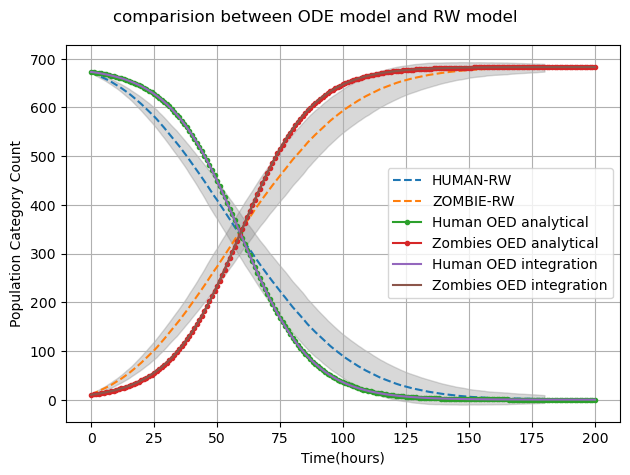

In [20]:
fig, ax = plt.subplots()
plot_mc_results(ax = ax, mc_averaged_data=mcmodel.averaged_mc_df)
ax.plot(t_ana, S_ana,'.-', label='Human OED analytical')
ax.plot(t_ana, Z_ana,'.-', label='Zombies OED analytical')

ax.plot(t_ode, S_ode,'-', label='Human OED integration')
ax.plot(t_ode, Z_ode,'-', label='Zombies OED integration')

ax.legend()
fig.suptitle('comparision between ODE model and RW model')
ax.set(xlabel='Time(hours)', ylabel='Population Category Count')
plt.tight_layout()

**Question 1:** How does your Monte Carlo random walk prediction compare with the continuum (ODE) model in equation (3)? (To answer this question you
need to estimate $\beta$ from the random walk simulation and apply your estimate of $\beta$ in equation (3) and compare the two simulations).

Both RW model and ODEs-based model exhibit a similar overall trend of dynamics of infection spreading. However, ODEs-based model shows a smooth decline at the beginning and then follows with a steeper and gradual decline in the human population, while RW model displays a swift virus spreading with a rapid decline from the start and then follows with a gradual and smooth decline in the human population. We can observe that the ODEs-based model is largely outside the range of confidence interval of RW model. This may explained by the coarsity of the deterministic ODEs-based SR model when a constant transmission rate is assumed. This model lacks the representation of uncertainty inherent in the RW simulations. This absence emphasizes the value of stochastic models in understanding the range of possible outbreak trajectories. The ODE model also has an inherent assumption that the population is 'well mixed', that is every susceptible individual has equal probability of meeting every other individual in the population. This can explain the slow growth of infection initially when only a few zombies are present vs very rapid infection spread later on when the number of infection sources (zombies) increase. 

The comparative simulation analysis reveals how the choice between stochastic versus deterministic approaches can significantly influence the outcomes of an epidemic. The RW model captures the potential uncertainty of an outbreak, offering valuable insights for public health planning and response strategies.

# Exercise 3: Scenario what happens in Sokndal and Dirdal?+
# Exercise 4: Compare your results with SZR model

In [21]:
# Dirdal
#
place = 'Dirdal'
zomb_life_exp = 48
params = {'population':683, 'infected':10, 'q':0.9, 'dp': 1/zomb_life_exp,'nx':50, 'ny':50, 'T':700}
samples = 100 # increase samples for final submission
mcmodel=MCRW(samples=samples)
_ = mcmodel.run_mc(**params)

In [22]:
mcmodel.find_beta_tau()
beta = mcmodel.avg_beta
tau = mcmodel.avg_tau
a = BucketModel(beta=beta,tau=tau, T=700, size = 700)
#t_ana,S_ana,Z_ana = a.ODE_analytical()
t_ode,soln = a.ODE_SZ_model()
S_ode, Z_ode,D_ode = soln[:,0],soln[:,1], soln[:,2]

/tmp/ipykernel_659/4163414050.py:81: RuntimeWarning: invalid value encountered in divide
  beta = (S[1:]-S[:-1])*N/(S[1:]*Z[1:])
/tmp/ipykernel_659/4163414050.py:82: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/beta != 0)[0]
/tmp/ipykernel_659/4163414050.py:85: RuntimeWarning: divide by zero encountered in divide
  tau = ((D[1:]-D[:-1])/Z[1:])
/tmp/ipykernel_659/4163414050.py:85: RuntimeWarning: invalid value encountered in divide
  tau = ((D[1:]-D[:-1])/Z[1:])
/tmp/ipykernel_659/4163414050.py:86: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/tau != 0)[0]


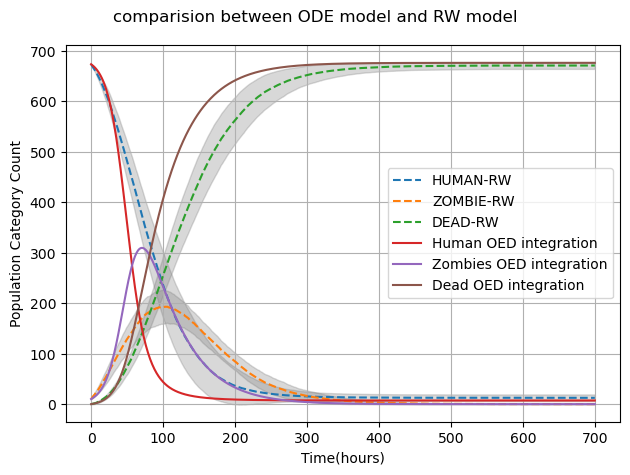

In [23]:
fig, ax = plt.subplots()
plot_mc_results(ax = ax, mc_averaged_data=mcmodel.averaged_mc_df, cats=['HUMAN', 'ZOMBIE', 'DEAD'])

ax.plot(t_ode, S_ode,'-', label='Human OED integration')
ax.plot(t_ode, Z_ode,'-', label='Zombies OED integration')
ax.plot(t_ode, D_ode,'-', label='Dead OED integration')


ax.legend()
fig.suptitle(f'comparision between ODE model and RW model for {place}')
ax.set(xlabel='Time(hours)', ylabel='Population Category Count')
plt.tight_layout()

In [24]:
# Sokndal
#
place = 'Sokndal'
zomb_life_exp = 24
params = {'population':683, 'infected':10, 'q':0.9, 'dp': 1/zomb_life_exp,'nx':50, 'ny':50, 'T':700}
samples = 100
mcmodel=MCRW(samples=samples)
_ = mcmodel.run_mc(**params)

In [25]:
mcmodel.find_beta_tau()
beta = mcmodel.avg_beta
tau = mcmodel.avg_tau
a = BucketModel(beta=beta,tau=tau, T=700, size = 700)
#t_ana,S_ana,Z_ana = a.ODE_analytical()
t_ode,soln = a.ODE_SZ_model()
S_ode, Z_ode,D_ode = soln[:,0],soln[:,1], soln[:,2]

/tmp/ipykernel_659/4163414050.py:81: RuntimeWarning: invalid value encountered in divide
  beta = (S[1:]-S[:-1])*N/(S[1:]*Z[1:])
/tmp/ipykernel_659/4163414050.py:82: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/beta != 0)[0]
/tmp/ipykernel_659/4163414050.py:85: RuntimeWarning: divide by zero encountered in divide
  tau = ((D[1:]-D[:-1])/Z[1:])
/tmp/ipykernel_659/4163414050.py:85: RuntimeWarning: invalid value encountered in divide
  tau = ((D[1:]-D[:-1])/Z[1:])
/tmp/ipykernel_659/4163414050.py:86: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/tau != 0)[0]


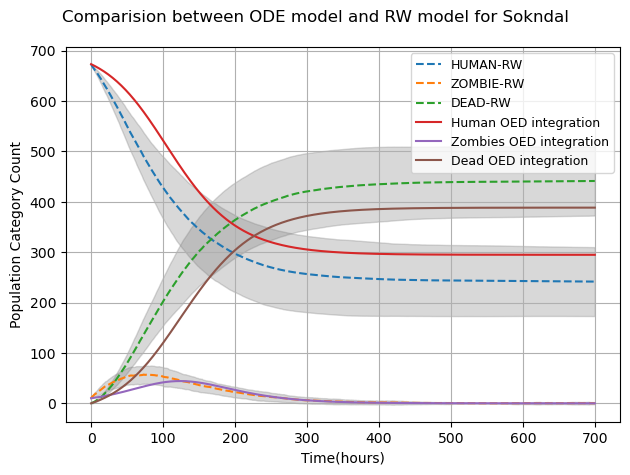

In [26]:
fig, ax = plt.subplots()
plot_mc_results(ax = ax, mc_averaged_data=mcmodel.averaged_mc_df, cats=['HUMAN', 'ZOMBIE', 'DEAD'])

ax.plot(t_ode, S_ode,'-', label='Human OED integration')
ax.plot(t_ode, Z_ode,'-', label='Zombies OED integration')
ax.plot(t_ode, D_ode,'-', label='Dead OED integration')


ax.legend(fontsize=9)
fig.suptitle(f'Comparision between ODE model and RW model for {place}')
ax.set(xlabel='Time(hours)', ylabel='Population Category Count')
plt.tight_layout()

**EX 3 Question 1:** Assume an average life expectancy of zombies of 48 (hours) and 24 (hours) in Dirdal and Sokndal respectively. What happens in the two villages?


In Dirdal, as the life expectancy of zombies of 48 hours is assumed, we observe a rapid drop in the human population and it remains with a steep declining curve, with a severe death rate and the entire human population exposed to the zombie virus after t = 230 hours. while in Soknal, instead, the zombie's lifespan of 24 hours is assumed, the human population exhibits a much smoother and gradual decline and moderate death rate. After 700 hours, a large number of individuals remain unexposed to the zombie virus.

**EX 3 Question 2:** For future zombie attacks: What is approximately the highest life expectancy of zombies, where humans still survive?

The maximum life expectancy for zombies in Dirdal, where humans persist, is around 300 hours. Beyond 300 hours, all zombies perish. On the contrary, in Sokndal, where a considerable number of individuals survive, a zombie's life expectancy is also prolonged, reaching from 300 hours to 700 hours and the death rate curve flattens out.

**EX 4 Question 1:** How does your predictions in the previous exercise compare with a continuum (ODE) model?

In Dirdal, the RW SZR model exhibits a comparable pattern of the ODEs SZR model. However, the rate of human population decrease differs, as well as the death rate. It represents the similar trend we observed in the previous comparison of the RW and ODEs model. as the RW model captures the uncertainty of real-world scenarios while the ODEs model assumes a uniform rate of infection spread. It is evident when the survival lifespan of a zombie virus is significantly extended. However, in Soknal, RW model exhibits a great match of the ODEs model. Most of the prediction curves of ODEs are within the error range of mean +- standard deviation of RW model.

# PLEASE check if we are referring the DIRDAL AND SOKNDAL correctly.

## EX 4:  Question 2: For future zombie attacks: What is approximately the highest life expectancy of zombies, where humans still survive?

In [27]:
humans_left = []
zombies_left = []
zle = range(20,100,5)
for zomb_life_exp in zle:
    params = {'population':683, 'infected':10, 'q':0.9, 'dp': 1/zomb_life_exp,'nx':50, 'ny':50, 'T':500}
    samples = 100
    mcmodel=MCRW(samples=samples)
    _ = mcmodel.run_mc(**params)
    a = mcmodel.averaged_mc_df
    humans_left.append(a['HUMAN','mean'].to_numpy()[-1])
    zombies_left.append(a['ZOMBIE','mean'].to_numpy()[-1])
    #print(f'zombie life expectancy {zomb_life_exp}\n', a.loc[a.index[-1]])
    #plot_mc_results(ax = ax, mc_averaged_data=mcmodel.averaged_mc_df, cats=['HUMAN', 'ZOMBIE', 'DEAD'], show_band=False)


In [28]:
%matplotlib inline

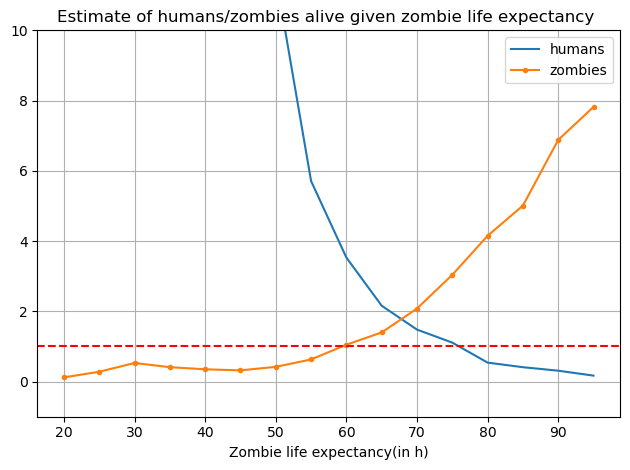

In [29]:
fig, ax = plt.subplots()
ax.plot(zle,humans_left, label= 'humans')
ax.plot(zle,zombies_left,'.-', label= 'zombies')
ax.set(title='Estimate of humans/zombies alive given zombie life expectancy ', xlabel='Zombie life expectancy(in h)')
ax.grid()
ax.axhline(1, linestyle = '--', color= 'r')
ax.legend()
ax.set(ylim=[-1,10])
plt.tight_layout()

In [30]:
np.interp(1, zombies_left, zle), np.interp(0.5, zombies_left, zle)

(59.404761904761905, 29.4)

**Discussion** :Humans survive if there is at least one human present and less than 1 zombie
We ran a sensitivity analysis for number of zombie and humans left for various 'Zombie life expectancy'.

for zombie life expectancy of 59h less than one zombie survives 

# ^ this can be expanded a little 

In [31]:
_df =  mcmodel.modelresults_df
_df = _df[_df.sim_no==0]

In [32]:
show_Zombieland(_df)

# Create your own scenario

The Zombie apocalypse has reached in Norway. The zombies are smart and they have strategized that if 10 zombies enter a town/village, they can convert everyone in the place. Oslo being ground zero for the arrival of zombies in Norway, is now overrun with zombies (but no one can tell the difference!). The good news is that scientists at SUS, Stavanger have been able to make a vaccine and ship it to every town/village in norway before the zombies arrive there. Much like the Borgs, their whole mission of a zombie is to assimilate the healthy population. Our smart zombies have taken over the NRK headquarters in Oslo and start spreading disinformation about the dangers of the vaccine and the adverse effects it can have, **especially** if you have a 5G cell tower in the vicinity. The disinformation has an effect and some part of the population has distrust of the vaccine and refuses to take them. The rest of the population takes the vaccine as soon as its available (and more importantly before the zombies arrive). 

The zombies send 10 zombie-missionaries (zombies) to each town in Norway to convert the town.  The towns people will try to kill the zombies or set traps randomly around the town (so zombies can die even where people are not present). The ife expectancy of the zombies is 24 hours. Only anti-vaxx individuals are susceptible to zombies' power of persuasion.   

We will now vary to percentage of the population that is vaccinated and check 

In [33]:
humans_left = []
humans_at_start =[]
zombies_left = []
zomb_life_exp = 24
params = {'population':683, 'infected':10, 'q':0.9, 'dp': 1/zomb_life_exp,'nx':50, 'ny':50, 'T':500}
samples = 100
p_vaxs=np.linspace(0,0.999,6)
print(p_vaxs)
for p_vax in p_vaxs:
    params['p_vax']=p_vax
    
    mcmodel=MCRW(samples=samples)
    _ = mcmodel.run_mc(**params)
    a = mcmodel.averaged_mc_df
    #print(a)
    humans_left.append(a['HUMAN','mean'].to_numpy()[-1])
    humans_at_start.append(a['HUMAN','mean'].to_numpy()[0])
    zombies_left.append(a['ZOMBIE','mean'].to_numpy()[-1])
print(humans_at_start, humans_left)
humans_at_start = np.array(humans_at_start)
humans_left = np.array(humans_left)
survival_percentage  = humans_left/humans_at_start

[0.     0.1998 0.3996 0.5994 0.7992 0.999 ]
[673.0, 539.0, 404.0, 270.0, 135.0, 1.0] [231.52, 298.24, 297.87, 235.16, 123.63, 0.97]


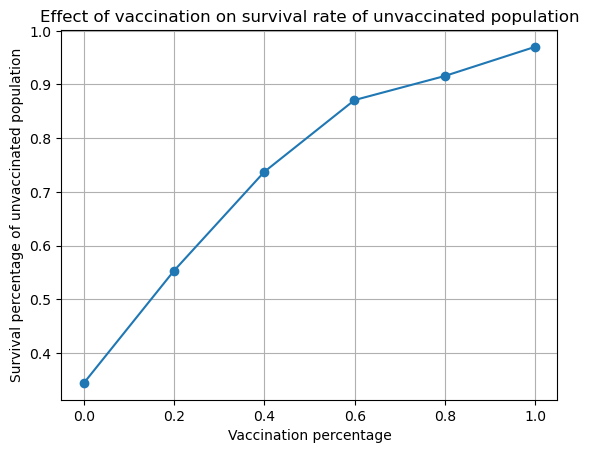

In [34]:
fig, ax = plt.subplots()
ax.plot(p_vaxs, survival_percentage, 'o-')
ax.set(xlabel='Vaccination percentage', ylabel='Survival percentage of unvaccinated population',
       title='Effect of vaccination on survival rate of unvaccinated population')
ax.grid()

**Discussion:**

the figure above shows the BLAH BLAH BLAH
even a low vaccination rate contributes to high survival rate of unvaccinated population (20% vaxxed 55% survive)
some more blah blah
write a bit about how even with 60% vaccination most unvaccinated survive (most =85% i guess)



### **Conclusion**: 

From this project work, it is noticeable that the stochastic RW model offers valuable insights into understanding of the range of possible epidemic outbreak trajectories and defining the control strategies. 

In our examination comparing the Random Walk (RW) and Ordinary Differential Equations (ODEs) models across different scenarios with varying input parameters, the RW model demonstrates a pattern comparable to that of the ODEs model. 

We also observe that the assumption of transmission rate ($\beta$) have a significantly impact on the RW and ODEs-based model. There some deviation from the two models. The outcome of trajectories of the two modeling methods differs due to the factor of transmission was assumed to be constant for of ODEs in the experiment. 

However, RW model can yield similar outcomes as the ODEs model when configured with the right set of parameters, such as a zombie lifespan of 24 hours. However, it remains some degree of uncertainties in the simulations, compared to ODEs model. 

A possible drawback of the RW model may require a large number of simulations to be performed. This in effect poses higher computational cost to our simulator. 

-----------------------------
### **Reflections**:

Partha: BLah blah, coming soon , blah blah



Jing: 

In this project, it is very educational and practical to implement the Monte Carlo Random Walk algorithm that can be applied in real-life complex disease-spreading scenarios. It provides the fascinating trajectories of human contact and how the virus spread among a certain number of the population and the realization of the infection spread animation is fun and vivid. Implementing both RW and ODEs models remains a challenging heavy coding task. 


### **References** clean up please: 

[1] Compartmental models in epidemiology, https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology   
[2] Markov chain, https://en.wikipedia.org/wiki/Markov_chain   
[3] Aksel Hiorth. Modeling and Computational Engineering. https://github.com/ahiorth/CompEngineering, 2022.  
[4] Xin Li, Jin-Xuan Yang, Controlling the spread of infectious diseases by using random walk method to remove many important links, 2023  
[5] Christos Gkantsidis, Milena Mihail, Amin Saberi, Random walks in peer-to-peer networks: Algorithms and evaluation, 2005  
[6] Douglas Kelker. A Random Walk Epidemic Simulation. Journal of the American Statistical Association, 68(344):821–823, 1973.  
[7] S. Triambak and DP Mahapatra. A random walk Monte Carlo simulation study of COVID-19-like infection spread. Physica A: Statistical Mechanics and its Applications,2021.  
[8]   
[9]   
